# TaxPrep Demo Notebook
This notebook demonstrates generating synthetic data and running the local scoring service.

In [21]:
# Cell 1: imports & settings
import sys, os
sys.path.append(os.path.abspath(".."))  # ✅ ensures parent folder is visible

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, classification_report
sns.set(style="whitegrid")

from dotenv import load_dotenv
load_dotenv()

# now this will work:
from scoring_service_azure import score_batch

OUT_DIR = Path("notebooks/output")
OUT_DIR.mkdir(parents=True, exist_ok=True)


## Evaluation (simple example)
You can compute metrics by adding ground-truth labels and comparing.

In [23]:
# Cell 2 — Generate synthetic dataset if not present (no customersatisfaction_eval.csv dependency)
from pathlib import Path
import pandas as pd
import numpy as np

OUT_DIR = Path("notebooks/output")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Try to use your helper function if available
try:
    from data_utils import load_or_generate_sample
    print("✅ Using data_utils.load_or_generate_sample() to create synthetic data...")
    df = load_or_generate_sample(200)
except Exception as e:
    print("⚠️ data_utils not available or failed, generating synthetic data manually:", e)
    np.random.seed(42)
    df = pd.DataFrame({
        "client_id": [f"C{i:04d}" for i in range(200)],
        "turnaround_time_days": np.random.poisson(7, size=200).clip(1, 25),
        "error_rate_pct": np.round(np.random.beta(1.5, 30, size=200) * 10, 2),
        "communication_count": np.random.randint(0, 6, size=200),
        "last_feedback_text": np.random.choice(
            ["Great service", "Late delivery", "Incorrect forms", "Helpful advisor"], size=200
        ),
    })

# Derive a pseudo “true_label” for evaluation
def true_label_from_row(r):
    s = 0.5
    if r["turnaround_time_days"] > 10:
        s -= 0.25
    if r["error_rate_pct"] > 3:
        s -= 0.2
    if r["communication_count"] < 2:
        s -= 0.05
    return "Dissatisfied" if s < 0.5 else "Satisfied"

df["true_label"] = df.apply(true_label_from_row, axis=1)

# Save synthetic dataset for reference
synthetic_path = OUT_DIR / "synthetic_eval.csv"
df.to_csv(synthetic_path, index=False)
print(f"✅ Synthetic dataset generated and saved at: {synthetic_path}")

len(df), df.columns.tolist()


✅ Using data_utils.load_or_generate_sample() to create synthetic data...
✅ Synthetic dataset generated and saved at: notebooks/output/synthetic_eval.csv


(200,
 ['client_id',
  'service_type',
  'turnaround_time_days',
  'error_rate_pct',
  'advisor_experience_years',
  'communication_count',
  'unresolved_tickets',
  'last_feedback_text',
  'true_label'])

In [ ]:
#Cell 3 — Run batch scoring (LLM or heuristic fallback)

In [7]:
# Cell 3: run scoring (this calls the scoring module)
# Optionally run on a subset for speed while tuning
sample_df = df.sample(n=min(len(df), 100), random_state=42).reset_index(drop=True)
results = score_batch(sample_df)
results_df = pd.DataFrame(results)
# merge back with original rows by client_id (or index)
merged = sample_df.copy()
merged = merged.reset_index(drop=True)
merged = pd.concat([merged, results_df.set_index(merged.index)], axis=1)
merged.head()


,client_id,service_type,turnaround_time_days,error_rate_pct,advisor_experience_years,communication_count,unresolved_tickets,last_feedback_text,true_label,client_id,label,confidence,top_drivers
0,C10095,Individual,10,6.25,6.26,0,0,Great service,Dissatisfied,C10095,Dissatisfied,0.20,"[{""factor"": ""error_rate_pct"", ""impact"": ""Mediu..."
1,C10015,Individual,12,3.66,4.43,3,0,Incorrect forms,Dissatisfied,C10015,Dissatisfied,0.30,"[{""factor"": ""turnaround_time_days"", ""impact"": ..."
2,C10030,Business,9,5.59,1.97,0,0,Incorrect forms,Dissatisfied,C10030,Dissatisfied,0.20,"[{""factor"": ""error_rate_pct"", ""impact"": ""Mediu..."
3,C10158,Individual,13,9.25,0.96,6,1,Helpful advisor,Dissatisfied,C10158,Dissatisfied,0.05,"[{""factor"": ""turnaround_time_days"", ""impact"": ..."
4,C10128,Consulting,7,3.29,4.21,6,2,Late delivery,Dissatisfied,C10128,Satisfied,0.50,"[{""factor"": ""error_rate_pct"", ""impact"": ""Mediu..."


In [9]:
# Cell 4: compute accuracy & precision/recall for 'Dissatisfied'
# Ensure you have a true_label column
if 'true_label' not in merged.columns:
    raise ValueError("Please provide ground truth column 'true_label' in dataset")

y_true = merged['true_label'].astype(str).values
y_pred = merged['label'].astype(str).values

acc = accuracy_score(y_true, y_pred)
prec, recall, f1, sup = precision_recall_fscore_support(y_true, y_pred, labels=['Dissatisfied','Satisfied'], zero_division=0)
print(f"Accuracy: {acc:.3f}")
print("Per-class precision / recall / f1:")
print(pd.DataFrame({
    "label": ['Dissatisfied','Satisfied'],
    "precision": prec,
    "recall": recall,
    "f1": f1,
    "support": sup
}))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, zero_division=0))


Accuracy: 0.900
Per-class precision / recall / f1:
          label  precision    recall        f1  support
0  Dissatisfied   0.963415  0.918605  0.940476       86
1     Satisfied   0.611111  0.785714  0.687500       14

Classification Report:
              precision    recall  f1-score   support

Dissatisfied       0.96      0.92      0.94        86
   Satisfied       0.61      0.79      0.69        14

    accuracy                           0.90       100
   macro avg       0.79      0.85      0.81       100
weighted avg       0.91      0.90      0.91       100



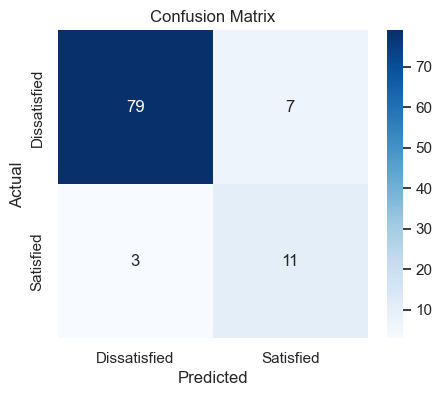

In [11]:
# Cell 5: confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=['Dissatisfied','Satisfied'])
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Dissatisfied','Satisfied'], yticklabels=['Dissatisfied','Satisfied'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


/var/folders/5y/5vg713hs19vdmkwwwk8bk_xh0000gp/T/ipykernel_20740/831190840.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = merged.groupby('conf_bin').agg(n=('confidence','count'), acc=('correct', 'mean'), avg_conf=('confidence','mean')).reset_index()


,conf_bin,n,acc,avg_conf
0,"(-0.001, 0.1]",24,1.000000,0.033333
1,"(0.1, 0.2]",4,1.000000,0.200000
2,"(0.2, 0.3]",49,1.000000,0.280612
3,"(0.3, 0.4]",0,NaN,NaN
4,"(0.4, 0.5]",23,0.565217,0.489130
5,"(0.5, 0.6]",0,NaN,NaN
6,"(0.6, 0.7]",0,NaN,NaN
7,"(0.7, 0.8]",0,NaN,NaN
8,"(0.8, 0.9]",0,NaN,NaN
9,"(0.9, 1.0]",0,NaN,NaN


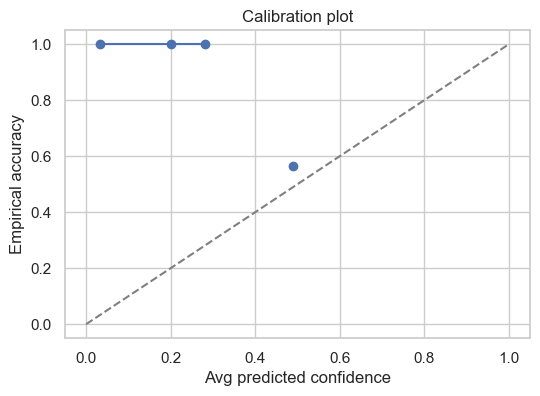

In [12]:
# Cell 6: calibration & reliability
merged['confidence'] = merged['confidence'].astype(float)
merged['correct'] = merged['label'] == merged['true_label']

# Binned calibration plot
bins = np.linspace(0,1,11)
merged['conf_bin'] = pd.cut(merged['confidence'], bins=bins, include_lowest=True)
calib = merged.groupby('conf_bin').agg(n=('confidence','count'), acc=('correct', 'mean'), avg_conf=('confidence','mean')).reset_index()
display(calib)
plt.figure(figsize=(6,4))
plt.plot(calib['avg_conf'], calib['acc'], marker='o')
plt.plot([0,1],[0,1], '--', color='gray')
plt.xlabel('Avg predicted confidence')
plt.ylabel('Empirical accuracy')
plt.title('Calibration plot')
plt.show()


In [14]:
# Cell 7 (fixed): parse top_drivers and summarize
import ast

def parse_top_drivers_cell(s):
    # Handles JSON strings, python-literal strings, lists, dicts, None
    if s is None:
        return []
    if isinstance(s, list):
        return s
    if isinstance(s, dict):
        return [s]
    if isinstance(s, str):
        s = s.strip()
        if s == "":
            return []
        # try JSON
        try:
            parsed = json.loads(s)
            if isinstance(parsed, list):
                return parsed
            if isinstance(parsed, dict):
                return [parsed]
        except Exception:
            pass
        # try ast.literal_eval
        try:
            parsed = ast.literal_eval(s)
            if isinstance(parsed, list):
                return parsed
            if isinstance(parsed, dict):
                return [parsed]
        except Exception:
            pass
        # fallback: return the raw string as one explain entry
        return [{"factor": "unknown", "impact": None, "explain": s}]
    # any other type
    return [{"factor": "unknown", "impact": None, "explain": str(s)}]

merged['top_dr_list'] = merged['top_drivers'].apply(parse_top_drivers_cell)

# Explode safely — create driver rows
driver_rows = []
for _, row in merged.iterrows():
    top_list = row.get('top_dr_list') or []
    for d in top_list:
        if isinstance(d, dict):
            driver_rows.append({
                'client_id': row.get('client_id'),
                'pred_label': row.get('label'),
                'true_label': row.get('true_label') if 'true_label' in row else None,
                'factor': d.get('factor'),
                'impact': d.get('impact'),
                'explain': d.get('explain')
            })
        else:
            driver_rows.append({
                'client_id': row.get('client_id'),
                'pred_label': row.get('label'),
                'true_label': row.get('true_label') if 'true_label' in row else None,
                'factor': str(d),
                'impact': None,
                'explain': None
            })

df_driver_rows = pd.DataFrame(driver_rows)

# show top factors for predicted Dissatisfied
top_factors = df_driver_rows[df_driver_rows['pred_label'] == 'Dissatisfied']['factor'].value_counts().head(20)
print("Top factors for predicted Dissatisfied:")
print(top_factors)


Top factors for predicted Dissatisfied:
factor
error_rate_pct          67
turnaround_time_days    60
communication_count      2
Name: count, dtype: int64


In [15]:
# Cell 8: numeric features comparison
numeric_cols = ['turnaround_time_days','error_rate_pct','communication_count']
stats = []
for c in numeric_cols:
    mean_pos = merged[merged['true_label']=='Dissatisfied'][c].mean()
    mean_neg = merged[merged['true_label']=='Satisfied'][c].mean()
    diff = mean_pos - mean_neg
    stats.append({'feature':c, 'mean_dissatisfied': mean_pos, 'mean_satisfied': mean_neg, 'difference': diff})
pd.DataFrame(stats).sort_values('difference', ascending=False)


,feature,mean_dissatisfied,mean_satisfied,difference
0,turnaround_time_days,12.441860,8.000000,4.441860
1,error_rate_pct,5.360581,1.530000,3.830581
2,communication_count,3.581395,3.142857,0.438538


In [17]:


results_path = OUT_DIR/"scoring_results_with_truth.csv"
merged.to_csv(results_path, index=False)
print("Saved results to", results_path)

# small text report
report = {
    'n_samples': len(merged),
    'accuracy': float(acc),
    'precision_dissatisfied': float(prec[0]),
    'recall_dissatisfied': float(recall[0]),
    'f1_dissatisfied': float(f1[0]),
}
with open(OUT_DIR/"eval_report.json","w") as f:
    json.dump(report,f,indent=2)
print("Evaluation report saved to", OUT_DIR/"eval_report.json")


Saved results to notebooks/output/scoring_results_with_truth.csv
Evaluation report saved to notebooks/output/eval_report.json


In [19]:
# Cell 9 — Generate synthetic eval data, score using Azure, and save output CSV
import sys, os
from pathlib import Path
import pandas as pd
import numpy as np
import json

# ensure parent directory is visible to imports
sys.path.append(os.path.abspath(".."))

# import the scoring service
from scoring_service_azure import score_batch

# --------------------------------------------------------------------
# 1️⃣ Generate synthetic evaluation dataset
# --------------------------------------------------------------------
np.random.seed(42)
n = 200
df = pd.DataFrame({
    "client_id": [f"C{i:04d}" for i in range(n)],
    "turnaround_time_days": np.random.poisson(7, size=n).clip(1, 25),
    "error_rate_pct": np.round(np.random.beta(1.5, 30, size=n) * 10, 2),
    "communication_count": np.random.randint(0, 6, size=n),
    "last_feedback_text": np.random.choice(
        ["Great service", "Late delivery", "Incorrect forms", "Helpful advisor"], size=n
    ),
})

# create a pseudo ground-truth for later evaluation
def compute_true_label(r):
    s = 0.5
    if r["turnaround_time_days"] > 10: s -= 0.25
    if r["error_rate_pct"] > 3: s -= 0.2
    if r["communication_count"] < 2: s -= 0.05
    return "Dissatisfied" if s < 0.5 else "Satisfied"

df["true_label"] = df.apply(compute_true_label, axis=1)

# --------------------------------------------------------------------
# 2️⃣ Run the scoring pipeline
# --------------------------------------------------------------------
print("Running GenAI scoring using Azure pipeline ... this may take a few seconds ⏳")
results = score_batch(df)
res = pd.DataFrame(results)

# merge safely (avoid duplicate columns)
if "client_id" in df.columns and "client_id" in res.columns:
    res = res.drop(columns=["client_id"])
out = pd.concat([df.reset_index(drop=True), res.reset_index(drop=True)], axis=1)

# --------------------------------------------------------------------
# 3️⃣ Save outputs to notebooks/output/
# --------------------------------------------------------------------
output_dir = Path("notebooks/output")
output_dir.mkdir(parents=True, exist_ok=True)
out_path = output_dir / "scored_eval.csv"
out.to_csv(out_path, index=False)

print(f"✅ Scoring complete — saved results to: {out_path}")
display(out.head(10))


Running GenAI scoring using Azure pipeline ... this may take a few seconds ⏳
✅ Scoring complete — saved results to: notebooks/output/scored_eval.csv


,client_id,turnaround_time_days,error_rate_pct,communication_count,last_feedback_text,true_label,label,confidence,top_drivers
0,C0000,6,0.54,1,Helpful advisor,Dissatisfied,Dissatisfied,0.45,"[{""factor"": ""communication_count"", ""impact"": ""..."
1,C0001,7,0.13,0,Late delivery,Dissatisfied,Dissatisfied,0.45,"[{""factor"": ""communication_count"", ""impact"": ""..."
2,C0002,6,0.17,2,Great service,Satisfied,Satisfied,0.50,"[{""factor"": ""communication_count"", ""impact"": ""..."
3,C0003,7,0.81,5,Helpful advisor,Satisfied,Satisfied,0.50,"[{""factor"": ""communication_count"", ""impact"": ""..."
4,C0004,7,0.13,0,Great service,Dissatisfied,Dissatisfied,0.45,"[{""factor"": ""communication_count"", ""impact"": ""..."
5,C0005,4,0.48,5,Incorrect forms,Satisfied,Satisfied,0.50,"[{""factor"": ""communication_count"", ""impact"": ""..."
6,C0006,12,0.47,2,Great service,Dissatisfied,Dissatisfied,0.30,"[{""factor"": ""turnaround_time_days"", ""impact"": ..."
7,C0007,2,0.12,2,Great service,Satisfied,Satisfied,0.50,"[{""factor"": ""communication_count"", ""impact"": ""..."
8,C0008,7,1.21,1,Late delivery,Dissatisfied,Dissatisfied,0.45,"[{""factor"": ""communication_count"", ""impact"": ""..."
9,C0009,5,0.29,1,Great service,Dissatisfied,Dissatisfied,0.45,"[{""factor"": ""communication_count"", ""impact"": ""..."
